# Pre-Processing: Reduced Classes
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

## Approach 
In this notebook, I will create a subset of the original dataset that includes leukocites with more balanced class counts. Furthermore, I will reduce the problem to a binary classification problem.

In [1]:
import os
import pickle
import sys
sys.path.append('..')

import cv2 as cv
# from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from src import constants as con
from src.features import build_features as bf
from src.visualization import visualize as viz

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
%matplotlib inline

## Load Annotations File
The annotations files contains the list of images, which will be used for the features, and list of morphologies, which are the labels.

In [2]:
df_annotate = pd.read_csv(os.path.join(con.REFERENCES_DIR, 'annotations.dat'), sep=' ', 
                          names=['Image Dir', 'Morphology', 'First Re-Annotation', 'Second Re-Annotation'])

In [3]:
df_annotate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18365 entries, 0 to 18364
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Image Dir             18365 non-null  object
 1   Morphology            18365 non-null  object
 2   First Re-Annotation   1905 non-null   object
 3   Second Re-Annotation  1905 non-null   object
dtypes: object(4)
memory usage: 574.0+ KB


## Reduced Classes
First, lets examine the class count by leukocite type.

In [4]:
df_image_counts = viz.count_images(df_annotate)
df_image_counts.reset_index().loc[:, ['Morphology', 'Image Count']]

,Morphology,Image Count
0,NGS,8484
1,LYT,3937
2,MYO,3268
3,MON,1789
4,EOS,424
5,NGB,109
6,BAS,79
7,EBO,78
8,PMO,70
9,MYB,42


Let's only consider the first four leukocite morphologies. From this, I can create classes that are roughly equal.

In [5]:
morphology_subset = ['NGS', 'LYT', 'MYO', 'MON']

In [6]:
df_annotate_subset = df_annotate[df_annotate['Morphology'].isin(morphology_subset)]

In [7]:
df_image_subset_counts = viz.count_images(df_annotate_subset)
df_image_subset_counts.reset_index().loc[:, ['Morphology', 'Image Count']]

,Morphology,Image Count
0,NGS,8484
1,LYT,3937
2,MYO,3268
3,MON,1789


Let's make this a binary classification problem by defining the classes _NGS_ and _not NGS_.

In [11]:
df_annotate_subset.loc[:, 'Morphology'] = df_annotate_subset.loc[:, 'Morphology'].replace({'LYT': 'not NGC', 'MYO': 'not NGC', 'MON': 'not NGC'})

In [17]:
df_image_subset_counts = viz.count_images(df_annotate_subset)
df_image_subset_counts.reset_index().loc[:, ['Morphology', 'Image Count']]

,Morphology,Image Count
0,not NGS,8994
1,NGS,8484


**Observations:**
The class counts for morphology type and much closer now.

## Features and Labels
Select the features and labels from the annotations file.

In [18]:
X = df_annotate_subset['Image Dir'].values
y = df_annotate_subset['Morphology'].values

Print out a few items in the features array. These are image file names.

In [19]:
X[:5]

array(['LYT/LYT_0001.tiff', 'LYT/LYT_0002.tiff', 'LYT/LYT_0003.tiff',
       'LYT/LYT_0004.tiff', 'LYT/LYT_0005.tiff'], dtype=object)

Print out of few of the label values. These are leukocite morphology types.

In [20]:
y[:5]

array(['not NGS', 'not NGS', 'not NGS', 'not NGS', 'not NGS'],
      dtype=object)

## Flatten Images
Load each image and flatten into a one-dimensional array.
* Convert images to grayscale so they take up less memory on disk.

In [21]:
X_flat = bf.preprocess_images(X, flatten=True, gray=True, rescale=True, scale_factor=0.12)

Preprocessing Images:
 * Flattening.
 * Rescaling (12.00%).
 * Convert to grayscale.
It took 2.125 minutes to load and preprocess 17478 images.
The array of preprocessed images takes up 40.269 Mb of memory.


Display the preprocessed images.

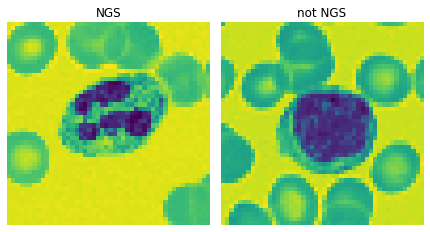

In [23]:
viz.display_preprocessed(X_flat, y, 4)

## Train-Test Split
Split the features and labels into training and test sets. I will set aside 20% of the dataset for testing and the rest for training.

First, let's examine the distribution in class counts for the labels.

In [24]:
print('Class fractions for the labels:')
pd.Series(y).value_counts(normalize=True)

Class fractions for the labels:


not NGS    0.51459
NGS        0.48541
dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

Examine class distributions between train and test sets.

In [27]:
print('Class fractions for labels in the training set:')
pd.Series(y_train).value_counts(normalize=True)

Class fractions for labels in the training set:


not NGS    0.51459
NGS        0.48541
dtype: float64

In [28]:
pd.Series(y_train).value_counts()

not NGS    7195
NGS        6787
dtype: int64

In [29]:
print('Class fractions for labels in the test set:')
pd.Series(y_test).value_counts(normalize=True)

Class fractions for labels in the test set:


not NGS    0.514588
NGS        0.485412
dtype: float64

## Save Train/Test Data
Save the training and test data to file. This data will not change during the modeling phase.

In [30]:
data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

In [31]:
training_directory = 'gray_rescale12_binary'

In [32]:
for key, value in data_dict.items():
    outfile = open(os.path.join(con.PROCESSED_DATA_DIR, training_directory, key), 'wb')
    pickle.dump(value, outfile)
    outfile.close()